# Imports

In [17]:
from sae_lens import SAE
import torch
import matplotlib.pyplot as plt
from IPython.display import IFrame
from utils.plotting_utils import draw_heatmap

# Constants

In [18]:
MODEL = "gemma-2-2b"
DATASET = "com2sense"
DATA_PATH = f"./experimental_data/{MODEL}/{DATASET}/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data

In [19]:
acts_resid = torch.load(DATA_PATH + "acts_resid.pt", map_location=device)
acts_exp_resid = torch.load(DATA_PATH + "acts_exp_resid.pt", map_location=device)
diff_resid = torch.load(DATA_PATH + "diffs_resid.pt", map_location=device)

C:\Users\wsr20\AppData\Local\Temp\ipykernel_20744\3212731613.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts_resid = torch.load(DATA_PATH + "acts_resid.pt", map_loc

In [20]:
print(acts_resid.shape)
print(acts_exp_resid.shape)
print(diff_resid.shape)

torch.Size([1874, 26, 2304])
torch.Size([1874, 26, 2304])
torch.Size([1874, 26, 2304])


# Look at the activations to decide which feature to look at

In [21]:
std_exp_resid = torch.std(acts_exp_resid, dim=0)
std_resid = torch.std(acts_resid, dim=0)
std_diffs_resid = torch.std(diff_resid, dim=0)
mean_exp_resid = torch.mean(acts_exp_resid, dim=0)
mean_resid = torch.mean(acts_resid, dim=0)
mean_diffs_resid = torch.mean(diff_resid, dim=0)

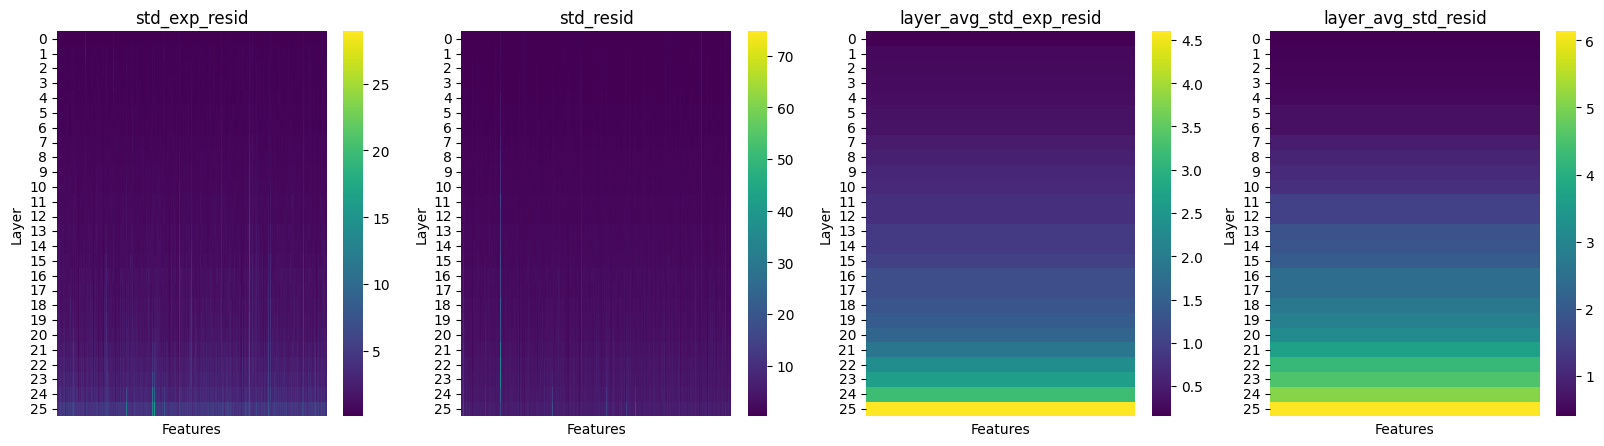

In [22]:
layer_avg_std_exp_resid = torch.mean(std_exp_resid, dim=1).unsqueeze(1)
layer_avg_std_resid = torch.mean(std_resid, dim=1).unsqueeze(1)
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
draw_heatmap(std_exp_resid, "std_exp_resid", axes[0])
draw_heatmap(std_resid, "std_resid", axes[1])
draw_heatmap(layer_avg_std_exp_resid, "layer_avg_std_exp_resid", axes[2])
draw_heatmap(layer_avg_std_resid, "layer_avg_std_resid", axes[3])
plt.show()

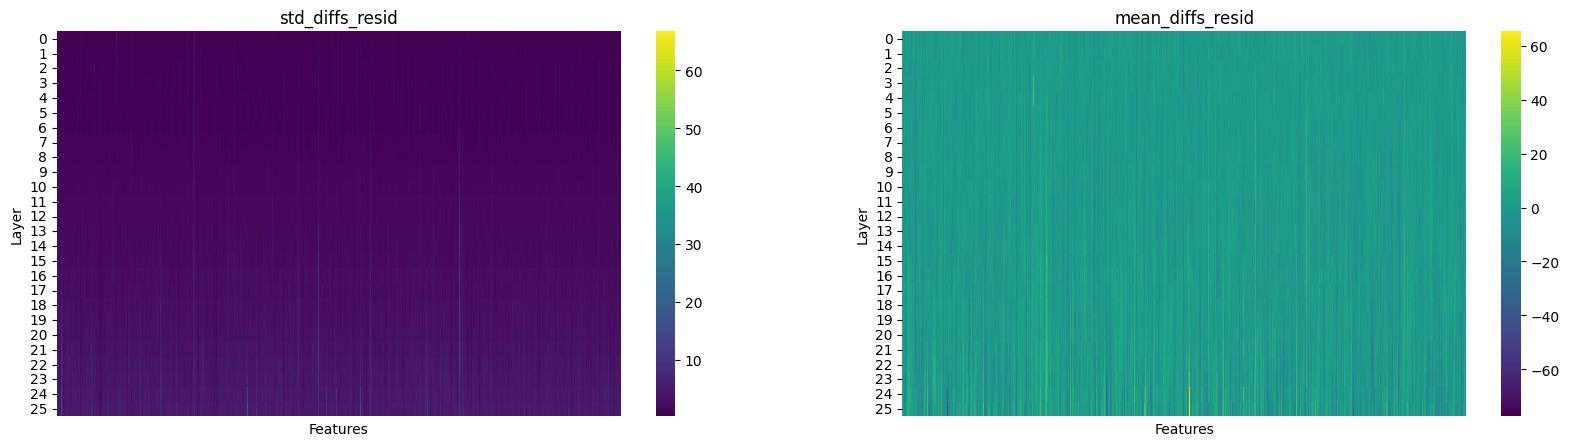

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
draw_heatmap(std_diffs_resid, "std_diffs_resid", axis=axes[0])
draw_heatmap(mean_diffs_resid, "mean_diffs_resid", axis=axes[1])
plt.show()

There seems to be a very high std neuron in the last layer with CoT. Let's take a look at it.

In [57]:
k = 20
def get_max_indeces(input: torch.Tensor, k: int):
    """
    Gets the indices of the maximum elements for each layer.
    args:
        input: The standard deviation of the activations, shape (layers, hidden_channels).
        k: Top k maximum standard deviations to return.
    returns:
        The indices of the maximum standard deviation for each layer.
    """
    indeces = []
    for i in range(input.shape[0]):
        indeces_layer_i = torch.argsort(input[i, :], dim=0, descending=True)[:k]
        indeces.append(indeces_layer_i)
    indeces = torch.stack(indeces)
    return indeces

cot_exp_indeces = get_max_indeces(mean_exp_resid, k)
cot_indeces = get_max_indeces(mean_resid, k)
cot_diffs_indeces = get_max_indeces(mean_diffs_resid, k)

cot_exp_acts = torch.gather(mean_exp_resid, 1, cot_exp_indeces)
cot_acts = torch.gather(mean_resid, 1, cot_indeces)
cot_diffs_acts = torch.gather(mean_diffs_resid, 1, cot_diffs_indeces)

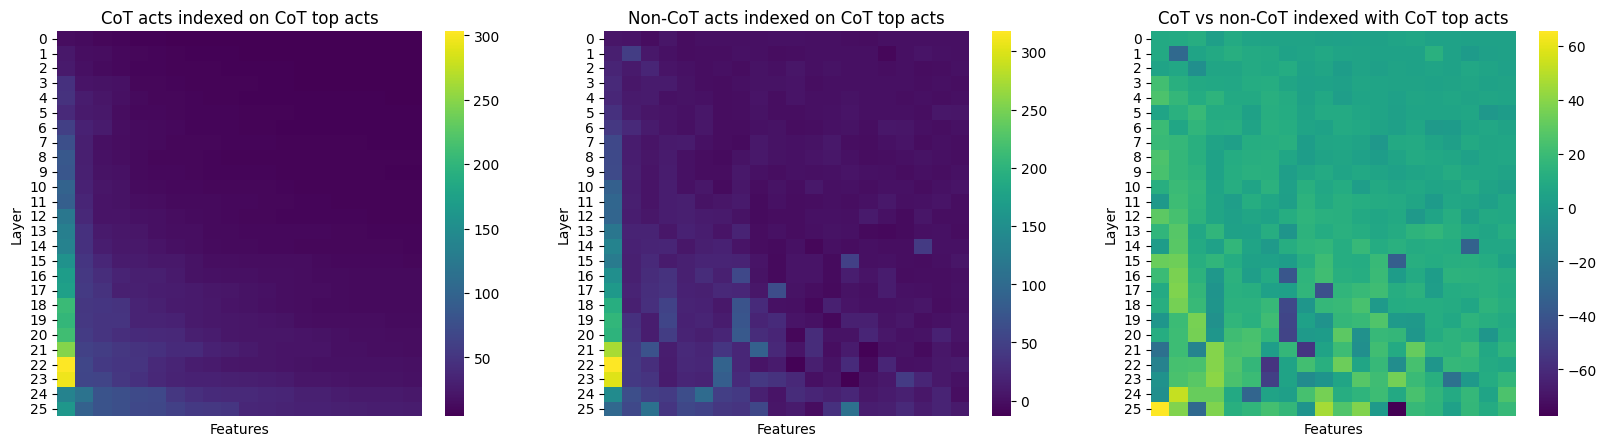

In [58]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
draw_heatmap(torch.gather(mean_exp_resid, 1, cot_exp_indeces), "CoT acts indexed on CoT top acts", axis=axes[0])
draw_heatmap(torch.gather(mean_resid, 1, cot_exp_indeces), "Non-CoT acts indexed on CoT top acts", axis=axes[1])
draw_heatmap(torch.gather(mean_diffs_resid, 1, cot_exp_indeces), "CoT vs non-CoT indexed with CoT top acts", axis=axes[2])
plt.show()

In [41]:
# print(cot_indeces)
print(cot_diffs_indeces)

tensor([[ 243, 1546,  533, 1570,  561, 1150,  535,  334, 1228,  714],
        [1546,  533,  561,  645,  153, 1150,  535,  714, 1228,  334],
        [1546,  533,  561, 1150, 1228,  645, 1570,  714, 1002, 2244],
        [ 535, 1002, 1546,  533, 1150,  561, 1570, 1228,  334, 1824],
        [ 535,  334, 1002,  533, 1546, 1570, 1150,  561, 1228, 1824],
        [ 334, 1570,  533, 1651, 1443, 1824,  588, 1150,  561, 1228],
        [ 334, 1570,  533, 1443, 1824, 1651, 1546, 1150, 1228,  561],
        [ 334, 1570, 1824, 1651,  533, 1443, 1150, 1228,  588, 1276],
        [ 334, 1570, 1651, 1824,  533, 1443, 1150, 1228, 2269,  588],
        [ 334, 1570, 1824, 1651,  533, 1443, 1150, 2269, 1228,  464],
        [1570, 1824, 1651,  533,  334, 1443, 2269,  588, 1150,  464],
        [1570, 1824, 1651,  533, 1443, 2269,  588,  464,  855, 1150],
        [ 334, 1570, 1651, 1824,  533, 2269,  588, 1443,  464,  855],
        [1570, 1651,  334, 1824,  588, 2269,  533,  948, 1443, 1169],
        [1570, 1651,

# Look at the activation via SAE

In [43]:
html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

layer = 1
feature_index = 1546

def get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=0):
    """
    Gets the html for the dashboard of gemma interpretation
    args:
        sae_release: The release of the SAE. Should be of the form "gemma-2-2b".
        sae_id: The id of the SAE. Should be of the form "<layer>-<SAE name>-<stream>-<scale>"
        feature_idx: The index of the feature to look at.
    """
    return html_template.format(sae_release, sae_id, feature_idx)

html = get_dashboard_html(sae_release = "gemma-2-2b", sae_id=f"{layer}-gemmascope-res-16k", feature_idx=feature_index)
IFrame(html, width=1200, height=600)